<a href="https://colab.research.google.com/github/niquibonnet/Mon-reve---webscraping/blob/main/webscraping_bonnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mon rêve - Projet de WebScrping

In [211]:
#Importation des différentes librairies
import pandas as pd
import bs4
from bs4 import BeautifulSoup
import requests
import csv

In [212]:
print('pandas version: {}'.format(pd.__version__))
print('bs4 version: {}'.format(bs4.__version__))
print('requests version: {}'.format(requests.__version__))
print('csv version: {}'.format(csv.__version__))

pandas version: 1.3.5
bs4 version: 4.6.3
requests version: 2.25.1
csv version: 1.0


In [ ]:
#fonction pour 
def get_url(search_term, pages):
    template = 'https://www.amazon.fr/s?k=panneau+solaire+van+am%C3%A9nag%C3%A9&crid=NB6GNAHTS5J6&sprefix=%2Caps%2C158&ref=nb_sb_ss_recent_3_0_recent'
    template2 = 'https://allo.solar/panneaux-solaires-photovoltaique.html'
    urls= []
    
    for i in range(2,pages):
        search_term= search_term.replace(' ','+')
        url= template.format(search_term, i)
        url2= template2.format(search_term, i)
        urls.append(url)
    return urls

In [ ]:
def scrape_record(item):
    atag= item.h2.a
    description= atag.text.strip()
    
    #Prix
    try:
        price_parent= item.find('span','a-price')
        price= price_parent.find('span', 'a-offscreen').text
    except AttributeError:
        return
    
    #Note
    try:
        rating= item.i.text.strip()[:3]
    except AttributeError:
        rating= 'None'
        
    #Nombre d'avis    
    try:
        review_count= item.find('span',{'class': 'a-size-base s-underline-text'}).text
    except AttributeError:
        review_count= 'None'
    
    record= (description, price, rating, review_count)
    
    return record

In [ ]:
def scrape_all_pages(urls):
    records= [] 
    
    for url in urls:
        headers= {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}
        page= requests.get(url, headers=headers) 
        soup= BeautifulSoup(page.content,'html.parser')

        results= soup.find_all('div',{'data-component-type':'s-search-result'})
        
        for item in results:
            record= scrape_record(item)
            if record:
                records.append(record)
                
    # On écrit dans un csv 
    
    with open("data.csv", 'w', newline='', encoding='utf-8') as f:
        writer= csv.writer(f)
        writer.writerow(['Description', 'Prix', 'Note/5', "Nombre d'avis"])
        writer.writerows(records)
    return records

In [ ]:
urls= get_url('panneaux solaires van aménagé',75)
records= scrape_all_pages(urls)

In [ ]:
df= pd.read_csv('data.csv')

In [ ]:
pd.set_option('display.max_rows', None)
df.head()
df.count()

Description      3417
Prix             3417
Note/5           3417
Nombre d'avis    3417
dtype: int64

In [ ]:
df = df.drop_duplicates()
df.count()

Description      116
Prix             116
Note/5           116
Nombre d'avis    116
dtype: int64

In [ ]:
df = df.sort_values(by='Note/5', ascending=False)
df = df[df['Note/5'] != "None"]
df = df[df["Nombre d'avis"] != "None"]
df.head()

,Description,Prix,Note/5,Nombre d'avis
92,XINPUGUANG Kit de Panneau Solaire 300w 12v: mo...,"188,99 €","5,0",(1)
51,XINPUGUANG Kit de Panneau Solaire 300w 12v: mo...,"188,99 €","5,0",1
32,FENNEK HIGHFIRE |Foyer extérieur | Filet en Ac...,"112,32 €","4,7",69
11,Renogy Kit de Panneaux Solaires Hors Réseau 20...,"259,99 €","4,6",1 125
76,"Renogy Panneau Solaire 175 W, Chargeur 12 V PV...","209,99 €","4,6",(402)


In [ ]:
import re
df["Nombre d'avis"] = df["Nombre d'avis"].apply(lambda x: re.sub(r'^[^\d]+', '', x))
df["Nombre d'avis"] = df["Nombre d'avis"].apply(lambda x: re.sub(r'[^\d]+$', '', x))
df["Nombre d'avis"] = df["Nombre d'avis"].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', '', x))

In [ ]:
df["Nombre d'avis"] = df["Nombre d'avis"].astype(float)

In [ ]:
df = df.sort_values(by="Nombre d'avis", ascending=True)
df = df.drop_duplicates()
df.head()

,Description,Prix,Note/5,Nombre d'avis
92,XINPUGUANG Kit de Panneau Solaire 300w 12v: mo...,"188,99 €","5,0",1.0
28,"HCKZ Panneau Solaire 100 W, Panneau Solaire Ha...","55,00 €","1,0",1.0
331,LZH FILTER Panneaux Solaires Polycristallins 2...,"74,00 €","3,0",2.0
74,XINPUGUANG 200w 12v Panneau Solaire Kit 2pcs 1...,"118,99 €","2,9",3.0
38,Monumen Kit panneau solaire de 200 W chargeur ...,"51,29 €","3,3",5.0


In [ ]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
liste_description=[]
for row in df['Description']:
  liste_description.append(str(row))
  
avis = ' '.join(liste_description).lower()
lemmatizer = WordNetLemmatizer()

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np

from wordcloud import WordCloud, ImageColorGenerator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


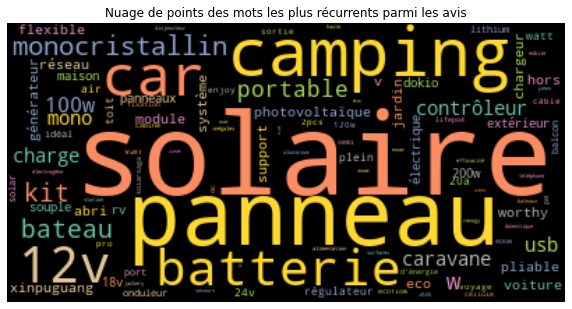

In [ ]:
stopwords_list=stopwords.words('french')
stopwords_list2=list(np.append(stopwords_list,['plu','très','a','alor','toujour',"c'est",'quand','alor','fait',"j'ai",'plus','depui','cette','si','depuis','tout','sans']))

wordcloud = WordCloud(stopwords = stopwords_list2, background_color='black', colormap='Set2',
                      collocations=False).generate(avis)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.title("Nuage de points des mots les plus récurrents parmi les avis")
plt.show()

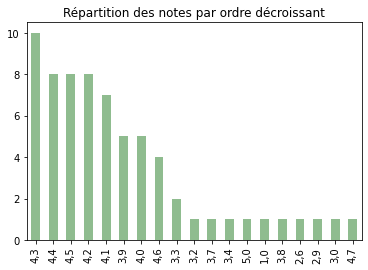

In [ ]:
df['Note/5'].value_counts().plot(kind='bar', color = 'darkseagreen')
plt.title("Répartition des notes par ordre décroissant")
plt.show()

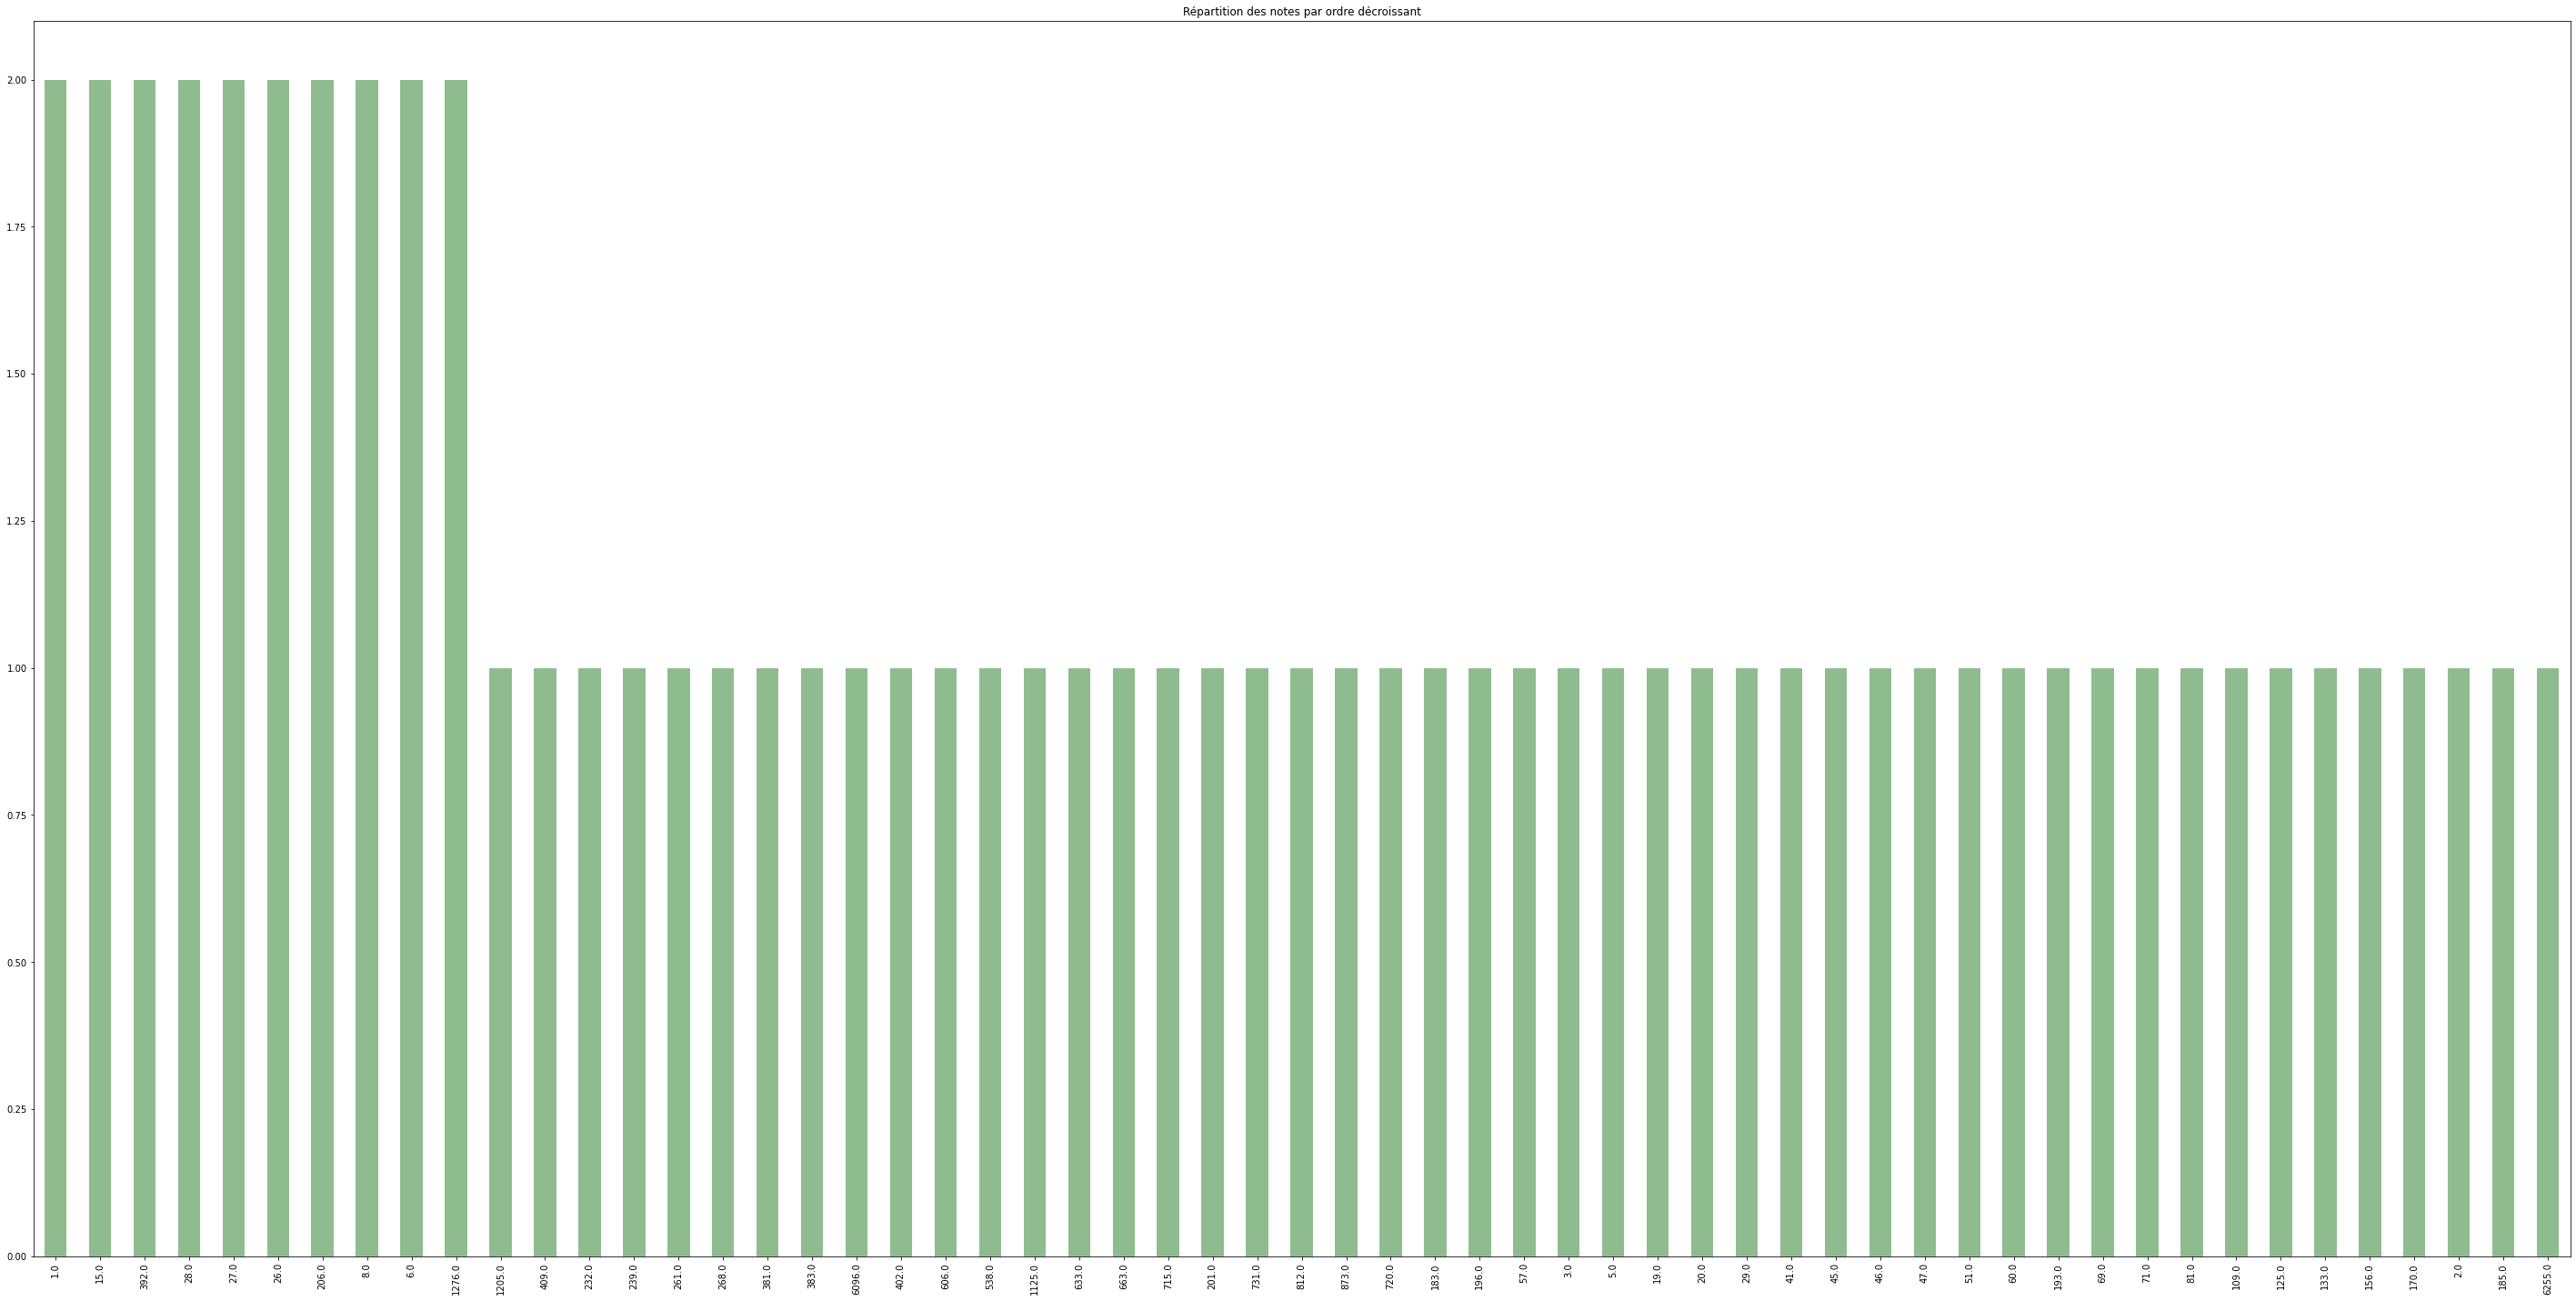

In [ ]:
df["Nombre d'avis"].value_counts().plot(kind='bar', color = 'darkseagreen')
plt.title("Répartition des notes par ordre décroissant")
plt.gcf().set_size_inches(50, 25)
plt.show()

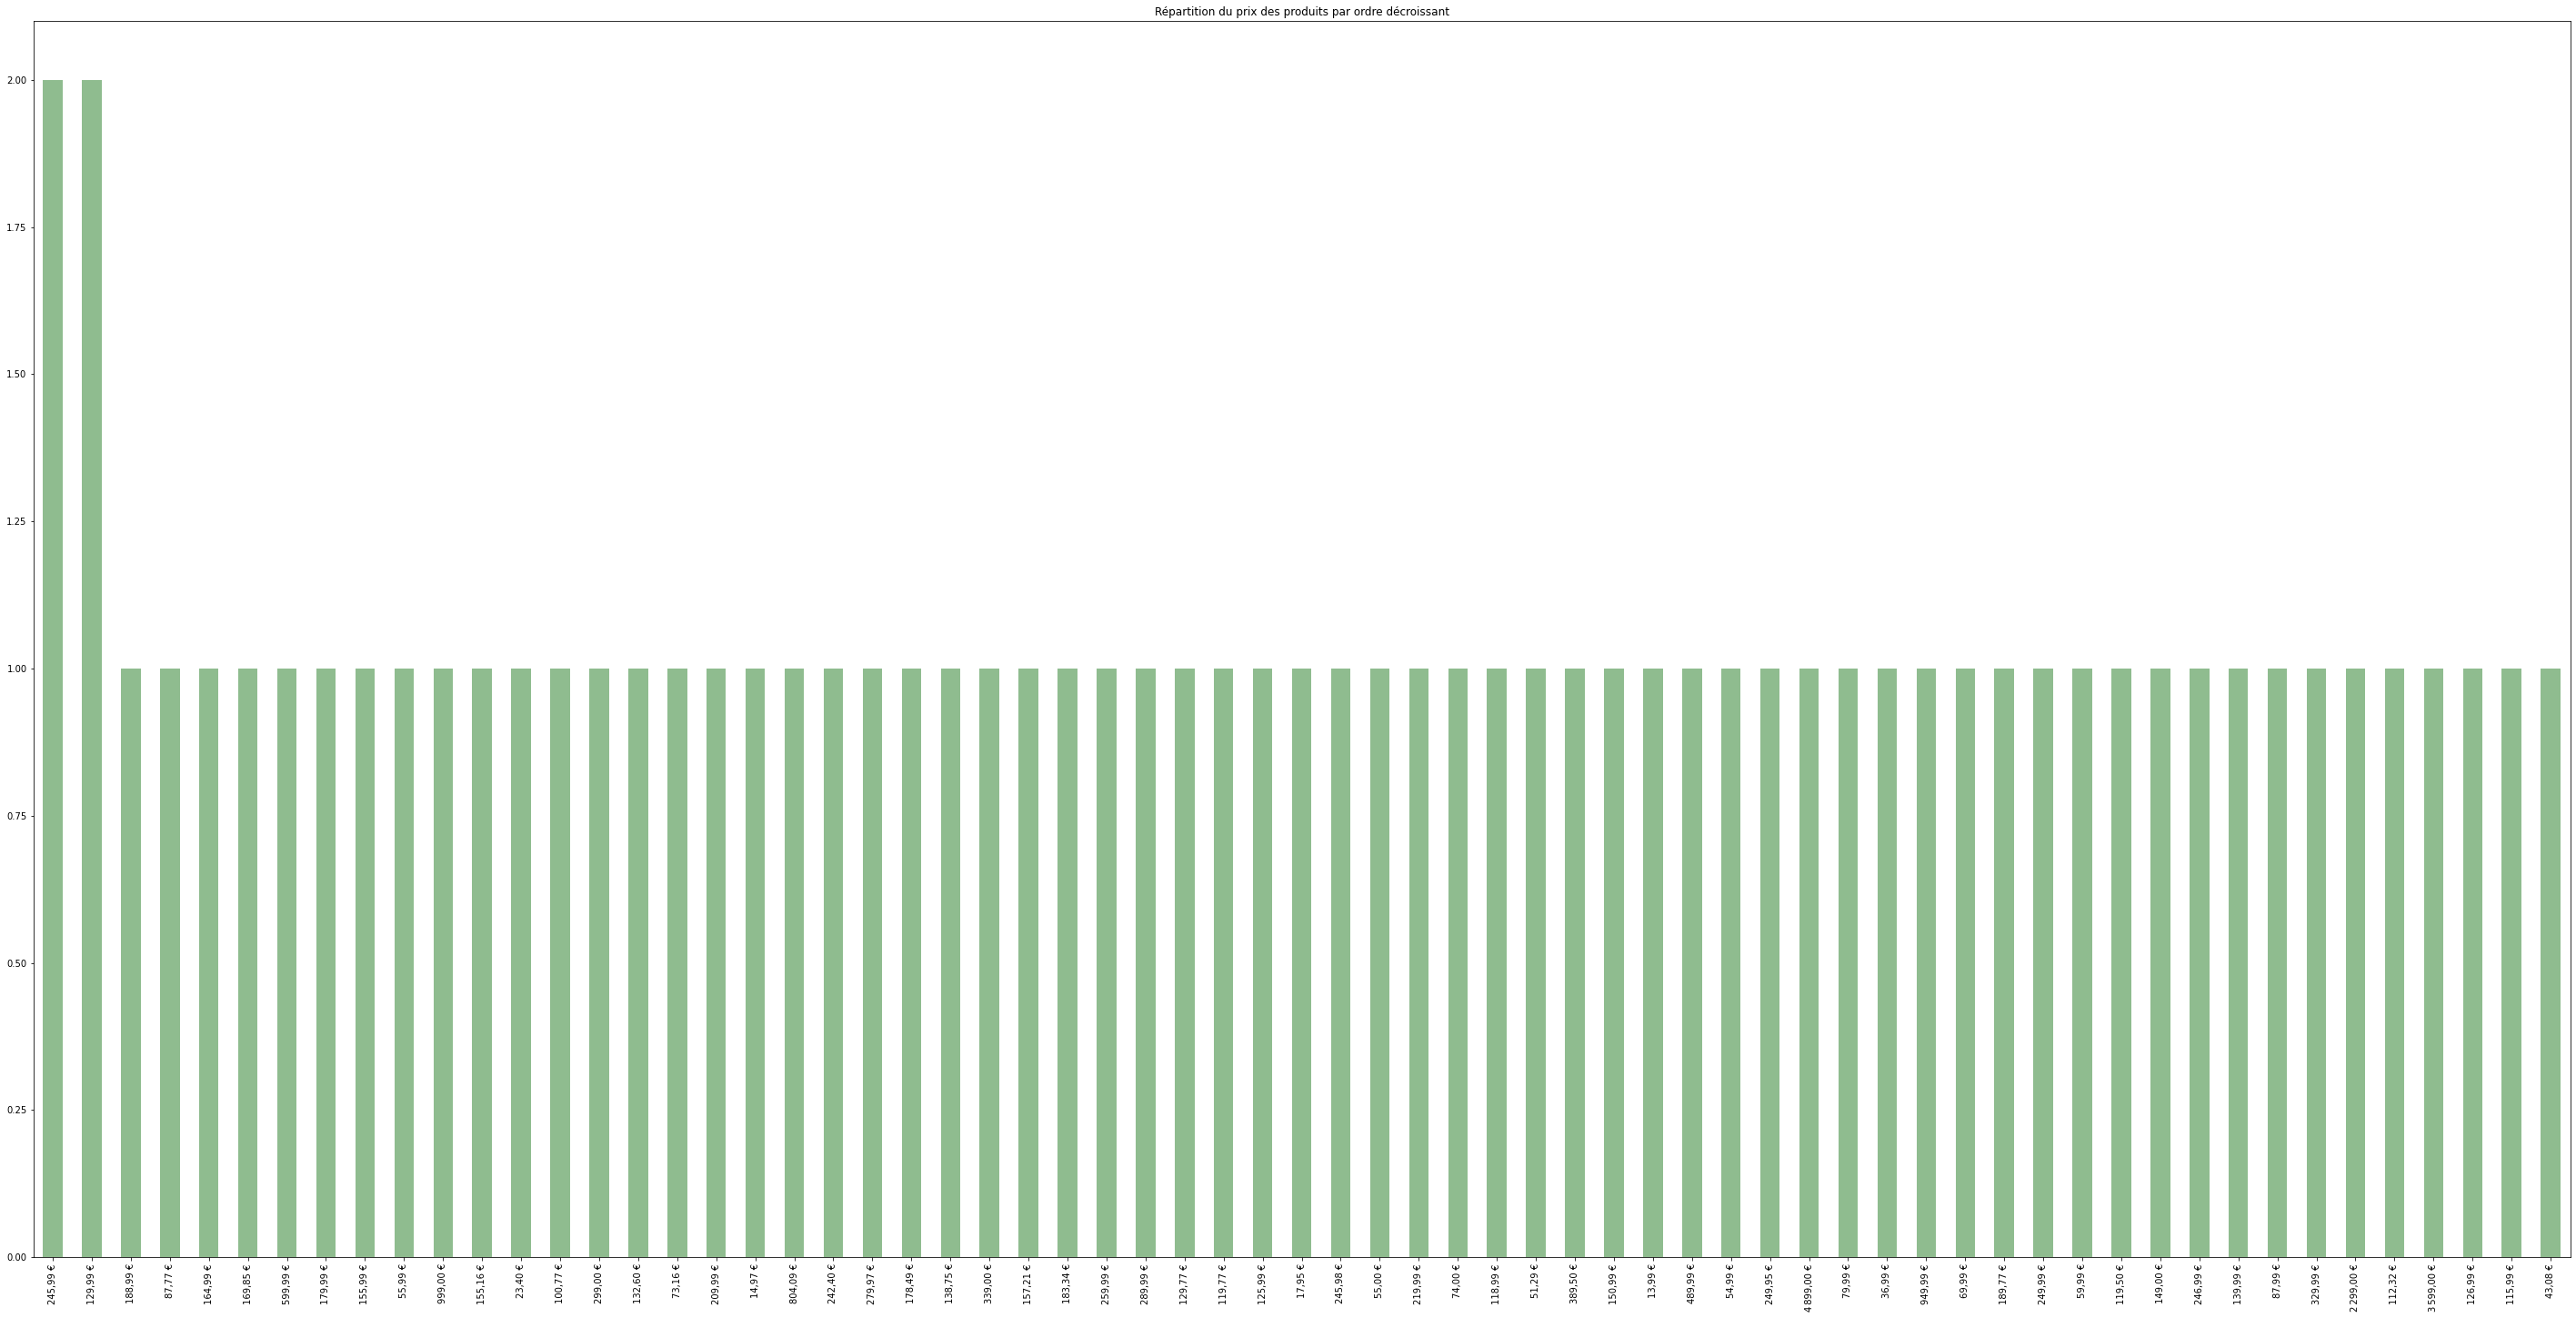

In [ ]:
df["Prix"].value_counts().plot(kind='bar', color = 'darkseagreen')
plt.title("Répartition du prix des produits par ordre décroissant")
plt.gcf().set_size_inches(50, 25)
plt.show()

In [ ]:
df = df[df["Note/5"] > "4,0"]
df.head()

,Description,Prix,Note/5,Nombre d'avis
92,XINPUGUANG Kit de Panneau Solaire 300w 12v: mo...,"188,99 €","5,0",1.0
62,SWAREY Générateur Solaire Portable S240 240Wh/...,"389,50 €","4,6",6.0
33,"Simmpatuu Disjoncteur photovoltaïque,2P 10A Di...","13,99 €","4,5",8.0
55,Kit panneau solaire 150 w / 12v monocristallin...,"249,95 €","4,1",15.0
0,ECOFLOW Générateur solaire DELTA Pro 3.6KWh/36...,"4 899,00 €","4,3",19.0


In [ ]:
df = df[df["Nombre d'avis"] > 100]
df.count()
df.head()

,Description,Prix,Note/5,Nombre d'avis
71,XINPUGUANG 200 W Kit 2 pcs 100 Watt 18 V Panne...,"115,99 €","4,2",109.0
99,DOKIO Panneau solaire pliable 150 W avec régul...,"189,77 €","4,2",125.0
70,"CTECHi Générateur Solaire Portable 240Wh, Géné...","245,98 €","4,4",133.0
97,Enjoy solar Mono 5 W 12V Panneau solaire monoc...,"17,95 €","4,3",170.0
8,Topsolar Panneau Solaire Flexible 100W 24V/12V...,"132,60 €","4,2",183.0


In [ ]:
df["Prix"] = df["Prix"].apply(lambda x: re.sub(r'[^\d]+$', '', x))
df

,Description,Prix,Note/5,Nombre d'avis
71,XINPUGUANG 200 W Kit 2 pcs 100 Watt 18 V Panne...,"115,99","4,2",109.0
99,DOKIO Panneau solaire pliable 150 W avec régul...,"189,77","4,2",125.0
70,"CTECHi Générateur Solaire Portable 240Wh, Géné...","245,98","4,4",133.0
97,Enjoy solar Mono 5 W 12V Panneau solaire monoc...,"17,95","4,3",170.0
8,Topsolar Panneau Solaire Flexible 100W 24V/12V...,"132,60","4,2",183.0
16,Station électrique portable EF ECOFLOW RIVER 2...,"299,00","4,5",185.0
107,Dokio 100W-12V Panneau Solaire MONO Souple Sem...,"100,77","4,1",193.0
105,Enjoy solar Mono 10 W 12V Panneau solaire mono...,"23,40","4,1",196.0
49,Enjoy solar Mono 140 W 12V Panneau solaire mon...,"155,16","4,4",201.0
61,BLUETTI Générateur Électrique EB3A avec Pannea...,"999,00","4,5",206.0


In [ ]:
df["Prix"] = df["Prix"].apply(lambda x: x.replace(",", ".") if type(x) == str else x)
df.head()

,Description,Prix,Note/5,Nombre d'avis
71,XINPUGUANG 200 W Kit 2 pcs 100 Watt 18 V Panne...,115.99,"4,2",109.0
99,DOKIO Panneau solaire pliable 150 W avec régul...,189.77,"4,2",125.0
70,"CTECHi Générateur Solaire Portable 240Wh, Géné...",245.98,"4,4",133.0
97,Enjoy solar Mono 5 W 12V Panneau solaire monoc...,17.95,"4,3",170.0
8,Topsolar Panneau Solaire Flexible 100W 24V/12V...,132.60,"4,2",183.0


In [ ]:
df

,Description,Prix,Note/5,Nombre d'avis
71,XINPUGUANG 200 W Kit 2 pcs 100 Watt 18 V Panne...,115.99,"4,2",109.0
99,DOKIO Panneau solaire pliable 150 W avec régul...,189.77,"4,2",125.0
70,"CTECHi Générateur Solaire Portable 240Wh, Géné...",245.98,"4,4",133.0
97,Enjoy solar Mono 5 W 12V Panneau solaire monoc...,17.95,"4,3",170.0
8,Topsolar Panneau Solaire Flexible 100W 24V/12V...,132.60,"4,2",183.0
16,Station électrique portable EF ECOFLOW RIVER 2...,299.00,"4,5",185.0
107,Dokio 100W-12V Panneau Solaire MONO Souple Sem...,100.77,"4,1",193.0
105,Enjoy solar Mono 10 W 12V Panneau solaire mono...,23.40,"4,1",196.0
49,Enjoy solar Mono 140 W 12V Panneau solaire mon...,155.16,"4,4",201.0
61,BLUETTI Générateur Électrique EB3A avec Pannea...,999.00,"4,5",206.0


In [ ]:
df = df[df["Description"].str.contains("12 V")]

In [ ]:
df = df.drop_duplicates()
df

,Description,Prix,Note/5,Nombre d'avis
99,DOKIO Panneau solaire pliable 150 W avec régul...,189.77,"4,2",125.0
77,ECO-WORTHY 130 Watt 12 Volt Panneau Solaire Mo...,164.99,"4,2",383.0
76,"Renogy Panneau Solaire 175 W, Chargeur 12 V PV...",209.99,"4,6",402.0
78,Renogy Panneau Solaire Souple 175 W 12 V Mono ...,289.99,"4,5",1205.0


In [ ]:
print(df.to_markdown())

|    | Description                                                                                                                                                                                   |   Prix | Note/5   |   Nombre d'avis |
|---:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------:|:---------|----------------:|
| 99 | DOKIO Panneau solaire pliable 150 W avec régulateur de charge solaire (PWM, 2 ports USB) pour batteries 12 V, avec sac de transport pour camping, solaire, convient pour camping-car, bateau. | 189.77 | 4,2      |             125 |
| 77 | ECO-WORTHY 130 Watt 12 Volt Panneau Solaire Monocristallin Souple Panneau Solaire Photovoltaïque pour Camping-cars Camper Van Bateaux et Autres Surfaces Inégales                             | 164.99 | 4,2      |             383 |
| 76 | Renogy Panneau Solaire 175 W, Chargeur 12 V P

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(df)

                                          Description    Prix Note/5  \
40  DOKIO Panneau solaire pliable 150 W avec régul...  189.77    4,2   
15  ECO-WORTHY 130 Watt 12 Volt Panneau Solaire Mo...  164.99    4,2   
55  Renogy Panneau Solaire 175 W, Chargeur 12 V PV...  209.99    4,6   
19  Renogy Panneau Solaire Souple 175 W 12 V Mono ...  289.99    4,5   

    Nombre d'avis  
40          125.0  
15          383.0  
55          401.0  
19         1205.0  


In [ ]:
from bs4 import BeautifulSoup
import urllib.request
import csv

In [ ]:
urlpage = 'https://www.amazon.fr/s?k=panneau+solaire+van+am%C3%A9nag%C3%A9&crid=10FYA1APBM8UI&sprefix=panneaux+solaires+van%2Caps%2C557&ref=nb_sb_ss_sc_2_19'

In [ ]:
# query the website and return the html to the variable 'page'
page = urllib.request.urlopen(urlpage)
# parse the html using beautiful soup and store in variable 'soup'
soup = BeautifulSoup(page, 'html.parser')

HTTPError: ignored